In [1]:
!pip install -r ../requirements.txt

You should consider upgrading via the 'c:\users\falchetto\appdata\local\programs\python\python39\python.exe -m pip install --upgrade pip' command.


# Configuration

In [2]:
ROOT_DIR = "../"
DATA_DIR = ROOT_DIR + "data/"

DATASET_2016_10a_FILENAME = DATA_DIR + "RML2016.10a_dict.pkl"

NN_NAME = 'CNN2'

DEFAULT_CONFIG_FILENAME = ROOT_DIR + "default.ini"

In [3]:
import configparser

config = configparser.ConfigParser()
config.read(DEFAULT_CONFIG_FILENAME)

NEURAL_NETWORK_NAME = config.get('NeuralNetworkNames', NN_NAME)
NEURAL_NETWORK_FILENAME = NEURAL_NETWORK_NAME + '.wts.h5'

TRAINING_SET_DIMENSION = config.getfloat('TrainingValues', 'TrainingSetSplitPercentage')
DROPOUT_RATE = config.getfloat('TrainingValues', 'DropoutRate')

# Set up some params 
NB_EPOCH = config.getint('TrainingValues', 'Epochs') # number of epochs to train on
BATCH_SIZE = config.getint('TrainingValues', 'BatchSize') # training batch size

# Imports

In [4]:
import sys
sys.path.append(ROOT_DIR)

import neural_networks
import datasetlib
import traintestsplitlib
import trainlib
import evaluationlib
import dftlib

# Dataset

## Dataset in a pandas Dataframe

In [5]:
dataset_df = datasetlib.load_dataset_dataframe(DATASET_2016_10a_FILENAME)

## Raw dataset

In [6]:
dataset_df

,IQ signals,Modulation_Label,SNR
0,"[[-0.0059014712, -0.0023458179, -0.00074506126...",QPSK,2
1,"[[0.0050326153, 0.00094379985, -0.0018932355, ...",QPSK,2
2,"[[0.0052390713, 0.0073890695, 0.007276459, 0.0...",QPSK,2
3,"[[-0.0019859935, -0.0071501383, -0.00527185, -...",QPSK,2
4,"[[0.006674405, 0.0028359746, 0.005630027, 0.00...",QPSK,2
...,...,...,...
219995,"[[0.0062732296, -0.0050519477, 0.006672171, 0....",BPSK,-18
219996,"[[-0.003903181, -0.0015884301, -0.00633375, 2....",BPSK,-18
219997,"[[-0.0105958255, 0.005601244, -0.012161784, 0....",BPSK,-18
219998,"[[-0.002136606, 0.00995837, 0.0059440527, -0.0...",BPSK,-18


# Neural network

## Configuration

In [7]:
config = configparser.ConfigParser()
config.read(DEFAULT_CONFIG_FILENAME)

SNR_LOWER_BOUND = config.getint('DatasetValues', 'SnrLowerBound')

NEURAL_NETWORK_NAME = config.get('NeuralNetworkNames', NN_NAME)
NEURAL_NETWORK_FILENAME = NEURAL_NETWORK_NAME + '.wts.h5'

TRAINING_SET_DIMENSION = config.getfloat('TrainingValues', 'TrainingSetSplitPercentage')
DROPOUT_RATE = config.getfloat('TrainingValues', 'DropoutRate')

# Set up some params 
NB_EPOCH = config.getint('TrainingValues', 'Epochs') # number of epochs to train on
BATCH_SIZE = config.getint('TrainingValues', 'BatchSize') # training batch size

## Data prepare

In [8]:
signals = datasetlib.signals(dataset_df)
labels = datasetlib.labels(dataset_df)

# [QPSQ, BPSK, ...]
mods = datasetlib.mods(dataset_df)
# [-18, -16, ...]
snrs = datasetlib.unique_snrs(dataset_df)

## Data transformation

In [9]:
signals = dftlib.all_I_Q_to_DFT(signals)

### Training and Test data partitioning

In [10]:
n_elements = len(signals)
training_set_percentage = TRAINING_SET_DIMENSION

train_index, test_index = traintestsplitlib.train_test_random_indexes_high_snr(dataset_df, training_set_percentage, SNR_LOWER_BOUND)

X_train, X_test, Y_train, Y_test = traintestsplitlib.split_x_y_train_test(signals, labels, mods, train_index, test_index)

## Build the Neural Network

In [11]:
in_shp = list(X_train.shape[1:])
print(X_train.shape)
print(in_shp)
classes = mods

(82500, 2, 128)
[2, 128]


In [12]:
model = neural_networks.rml201610a_VTCNN2_v2(in_shp)

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape (Reshape)            (None, 1, 2, 128)         0         
_________________________________________________________________
zero_padding2d (ZeroPadding2 (None, 1, 6, 128)         0         
_________________________________________________________________
conv1 (Conv2D)               (None, 1, 2, 256)         33024     
_________________________________________________________________
dropout (Dropout)            (None, 1, 2, 256)         0         
_________________________________________________________________
zero_padding2d_1 (ZeroPaddin (None, 1, 6, 256)         0         
_________________________________________________________________
conv2 (Conv2D)               (None, 1, 2, 80)          82000     
_________________________________________________________________
dropout_1 (Dropout)          (None, 1, 2, 80)          0

### Train the model

In [13]:
# perform training ...
#   - call the main training loop in keras for our network+dataset
filepath = NEURAL_NETWORK_FILENAME

history, model = trainlib.train(filepath, model, X_train, Y_train, X_test, Y_test, BATCH_SIZE, NB_EPOCH)

Epoch 1/100


 1/73 [..............................] - ETA: 14:53 - loss: 2.3987

 9/73 [==>...........................] - ETA: 0s - loss: 2.3963   

17/73 [=====>........................] - ETA: 0s - loss: 2.3929

25/73 [=========>....................] - ETA: 0s - loss: 2.3864

33/73 [============>.................] - ETA: 0s - loss: 2.3750

42/73 [================>.............] - ETA: 0s - loss: 2.3588



51/73 [===================>..........] - ETA: 0s - loss: 2.3418

60/73 [=======================>......] - ETA: 0s - loss: 2.3254

69/73 [===========================>..] - ETA: 0s - loss: 2.3100

73/73 [==============================] - ETA: 0s - loss: 2.3035

73/73 [==============================] - 13s 13ms/step - loss: 2.3020 - val_loss: 1.9716


Epoch 2/100
 1/73 [..............................] - ETA: 0s - loss: 2.0265

10/73 [===>..........................] - ETA: 0s - loss: 2.0111

19/73 [======>.......................] - ETA: 0s - loss: 1.9977

28/73 [==========>...................] - ETA: 0s - loss: 1.9836

37/73 [==============>...............] - ETA: 0s - loss: 1.9685

45/73 [=================>............] - ETA: 0s - loss: 1.9548

54/73 [=====================>........] - ETA: 0s - loss: 1.9395

62/73 [========================>.....] - ETA: 0s - loss: 1.9262

71/73 [============================>.] - ETA: 0s - loss: 1.9117

73/73 [==============================] - 0s 7ms/step - loss: 1.9070 - val_loss: 1.4673


Epoch 3/100


 1/73 [..............................] - ETA: 0s - loss: 1.6169

10/73 [===>..........................] - ETA: 0s - loss: 1.5890



19/73 [======>.......................] - ETA: 0s - loss: 1.5783

28/73 [==========>...................] - ETA: 0s - loss: 1.5703

37/73 [==============>...............] - ETA: 0s - loss: 1.5636

46/73 [=================>............] - ETA: 0s - loss: 1.5582

55/73 [=====================>........] - ETA: 0s - loss: 1.5531

64/73 [=========================>....] - ETA: 0s - loss: 1.5484

73/73 [==============================] - ETA: 0s - loss: 1.5442

73/73 [==============================] - 0s 6ms/step - loss: 1.5437 - val_loss: 1.3788


Epoch 4/100


 1/73 [..............................] - ETA: 0s - loss: 1.4115

10/73 [===>..........................] - ETA: 0s - loss: 1.4383

19/73 [======>.......................] - ETA: 0s - loss: 1.4442

28/73 [==========>...................] - ETA: 0s - loss: 1.4463

37/73 [==============>...............] - ETA: 0s - loss: 1.4473

46/73 [=================>............] - ETA: 0s - loss: 1.4476

55/73 [=====================>........] - ETA: 0s - loss: 1.4475

64/73 [=========================>....] - ETA: 0s - loss: 1.4473

73/73 [==============================] - ETA: 0s - loss: 1.4470

73/73 [==============================] - 0s 7ms/step - loss: 1.4469 - val_loss: 1.3498


Epoch 5/100
 1/73 [..............................] - ETA: 0s - loss: 1.4058



10/73 [===>..........................] - ETA: 0s - loss: 1.4166



19/73 [======>.......................] - ETA: 0s - loss: 1.4191

28/73 [==========>...................] - ETA: 0s - loss: 1.4200

37/73 [==============>...............] - ETA: 0s - loss: 1.4193

46/73 [=================>............] - ETA: 0s - loss: 1.4185

55/73 [=====================>........] - ETA: 0s - loss: 1.4176



64/73 [=========================>....] - ETA: 0s - loss: 1.4168



73/73 [==============================] - ETA: 0s - loss: 1.4159

73/73 [==============================] - 0s 6ms/step - loss: 1.4158 - val_loss: 1.3263


Epoch 6/100
 1/73 [..............................] - ETA: 0s - loss: 1.4022

10/73 [===>..........................] - ETA: 0s - loss: 1.3877

19/73 [======>.......................] - ETA: 0s - loss: 1.3908

28/73 [==========>...................] - ETA: 0s - loss: 1.3924

37/73 [==============>...............] - ETA: 0s - loss: 1.3920

46/73 [=================>............] - ETA: 0s - loss: 1.3918

55/73 [=====================>........] - ETA: 0s - loss: 1.3918

64/73 [=========================>....] - ETA: 0s - loss: 1.3917

73/73 [==============================] - ETA: 0s - loss: 1.3915

73/73 [==============================] - 0s 6ms/step - loss: 1.3914 - val_loss: 1.3115


Epoch 7/100
 1/73 [..............................] - ETA: 0s - loss: 1.3814

10/73 [===>..........................] - ETA: 0s - loss: 1.3626

19/73 [======>.......................] - ETA: 0s - loss: 1.3642

28/73 [==========>...................] - ETA: 0s - loss: 1.3650

37/73 [==============>...............] - ETA: 0s - loss: 1.3653

46/73 [=================>............] - ETA: 0s - loss: 1.3653

55/73 [=====================>........] - ETA: 0s - loss: 1.3657

64/73 [=========================>....] - ETA: 0s - loss: 1.3663

73/73 [==============================] - ETA: 0s - loss: 1.3667

73/73 [==============================] - 0s 6ms/step - loss: 1.3667 - val_loss: 1.2933


Epoch 8/100
 1/73 [..............................] - ETA: 0s - loss: 1.3282

10/73 [===>..........................] - ETA: 0s - loss: 1.3502

19/73 [======>.......................] - ETA: 0s - loss: 1.3528

28/73 [==========>...................] - ETA: 0s - loss: 1.3543

37/73 [==============>...............] - ETA: 0s - loss: 1.3546

46/73 [=================>............] - ETA: 0s - loss: 1.3545

55/73 [=====================>........] - ETA: 0s - loss: 1.3546

64/73 [=========================>....] - ETA: 0s - loss: 1.3546

72/73 [============================>.] - ETA: 0s - loss: 1.3546

73/73 [==============================] - 0s 7ms/step - loss: 1.3545 - val_loss: 1.2717


Epoch 9/100


 1/73 [..............................] - ETA: 0s - loss: 1.3443

10/73 [===>..........................] - ETA: 0s - loss: 1.3487

19/73 [======>.......................] - ETA: 0s - loss: 1.3462

28/73 [==========>...................] - ETA: 0s - loss: 1.3437

37/73 [==============>...............] - ETA: 0s - loss: 1.3424

46/73 [=================>............] - ETA: 0s - loss: 1.3413

55/73 [=====================>........] - ETA: 0s - loss: 1.3403

64/73 [=========================>....] - ETA: 0s - loss: 1.3394

72/73 [============================>.] - ETA: 0s - loss: 1.3388

73/73 [==============================] - 0s 7ms/step - loss: 1.3386 - val_loss: 1.2463


Epoch 10/100


 1/73 [..............................] - ETA: 0s - loss: 1.2946

10/73 [===>..........................] - ETA: 0s - loss: 1.3197

19/73 [======>.......................] - ETA: 0s - loss: 1.3235

28/73 [==========>...................] - ETA: 0s - loss: 1.3231

37/73 [==============>...............] - ETA: 0s - loss: 1.3228

46/73 [=================>............] - ETA: 0s - loss: 1.3228

55/73 [=====================>........] - ETA: 0s - loss: 1.3222

64/73 [=========================>....] - ETA: 0s - loss: 1.3212

73/73 [==============================] - ETA: 0s - loss: 1.3203

73/73 [==============================] - 0s 7ms/step - loss: 1.3202 - val_loss: 1.2300


Epoch 11/100
 1/73 [..............................] - ETA: 0s - loss: 1.2973

 9/73 [==>...........................] - ETA: 0s - loss: 1.2980

18/73 [======>.......................] - ETA: 0s - loss: 1.2997

27/73 [==========>...................] - ETA: 0s - loss: 1.3006

36/73 [=============>................] - ETA: 0s - loss: 1.3007

45/73 [=================>............] - ETA: 0s - loss: 1.3004

54/73 [=====================>........] - ETA: 0s - loss: 1.3001

63/73 [========================>.....] - ETA: 0s - loss: 1.2997

72/73 [============================>.] - ETA: 0s - loss: 1.2994

73/73 [==============================] - 0s 6ms/step - loss: 1.2994 - val_loss: 1.2144


Epoch 12/100
 1/73 [..............................] - ETA: 0s - loss: 1.2727

 9/73 [==>...........................] - ETA: 0s - loss: 1.2869

17/73 [=====>........................] - ETA: 0s - loss: 1.2903

26/73 [=========>....................] - ETA: 0s - loss: 1.2920

35/73 [=============>................] - ETA: 0s - loss: 1.2919

44/73 [=================>............] - ETA: 0s - loss: 1.2913

53/73 [====================>.........] - ETA: 0s - loss: 1.2906

62/73 [========================>.....] - ETA: 0s - loss: 1.2904

71/73 [============================>.] - ETA: 0s - loss: 1.2900

73/73 [==============================] - 0s 7ms/step - loss: 1.2899 - val_loss: 1.1958


Epoch 13/100
 1/73 [..............................] - ETA: 0s - loss: 1.3048

10/73 [===>..........................] - ETA: 0s - loss: 1.2733

19/73 [======>.......................] - ETA: 0s - loss: 1.2709

28/73 [==========>...................] - ETA: 0s - loss: 1.2702

37/73 [==============>...............] - ETA: 0s - loss: 1.2693

46/73 [=================>............] - ETA: 0s - loss: 1.2686

55/73 [=====================>........] - ETA: 0s - loss: 1.2678

64/73 [=========================>....] - ETA: 0s - loss: 1.2674

73/73 [==============================] - ETA: 0s - loss: 1.2673

73/73 [==============================] - 0s 6ms/step - loss: 1.2673 - val_loss: 1.1813


Epoch 14/100


 1/73 [..............................] - ETA: 0s - loss: 1.2778

10/73 [===>..........................] - ETA: 0s - loss: 1.2621

19/73 [======>.......................] - ETA: 0s - loss: 1.2617

28/73 [==========>...................] - ETA: 0s - loss: 1.2604

37/73 [==============>...............] - ETA: 0s - loss: 1.2591

46/73 [=================>............] - ETA: 0s - loss: 1.2583

54/73 [=====================>........] - ETA: 0s - loss: 1.2578

63/73 [========================>.....] - ETA: 0s - loss: 1.2574

72/73 [============================>.] - ETA: 0s - loss: 1.2571



73/73 [==============================] - 0s 7ms/step - loss: 1.2570 - val_loss: 1.1632


Epoch 15/100


 1/73 [..............................] - ETA: 0s - loss: 1.2465



10/73 [===>..........................] - ETA: 0s - loss: 1.2295



19/73 [======>.......................] - ETA: 0s - loss: 1.2315

28/73 [==========>...................] - ETA: 0s - loss: 1.2324

37/73 [==============>...............] - ETA: 0s - loss: 1.2332

46/73 [=================>............] - ETA: 0s - loss: 1.2339

55/73 [=====================>........] - ETA: 0s - loss: 1.2344

64/73 [=========================>....] - ETA: 0s - loss: 1.2348

73/73 [==============================] - ETA: 0s - loss: 1.2352



73/73 [==============================] - 0s 6ms/step - loss: 1.2352 - val_loss: 1.1487


Epoch 16/100
 1/73 [..............................] - ETA: 0s - loss: 1.2482

10/73 [===>..........................] - ETA: 0s - loss: 1.2427

19/73 [======>.......................] - ETA: 0s - loss: 1.2393

28/73 [==========>...................] - ETA: 0s - loss: 1.2347

37/73 [==============>...............] - ETA: 0s - loss: 1.2319

46/73 [=================>............] - ETA: 0s - loss: 1.2303

55/73 [=====================>........] - ETA: 0s - loss: 1.2289

64/73 [=========================>....] - ETA: 0s - loss: 1.2277

73/73 [==============================] - ETA: 0s - loss: 1.2268

73/73 [==============================] - 0s 7ms/step - loss: 1.2267 - val_loss: 1.1248


Epoch 17/100
 1/73 [..............................] - ETA: 0s - loss: 1.1415



10/73 [===>..........................] - ETA: 0s - loss: 1.1856

19/73 [======>.......................] - ETA: 0s - loss: 1.1920

28/73 [==========>...................] - ETA: 0s - loss: 1.1970

37/73 [==============>...............] - ETA: 0s - loss: 1.2001

45/73 [=================>............] - ETA: 0s - loss: 1.2018

54/73 [=====================>........] - ETA: 0s - loss: 1.2024

63/73 [========================>.....] - ETA: 0s - loss: 1.2026

72/73 [============================>.] - ETA: 0s - loss: 1.2028



73/73 [==============================] - 0s 6ms/step - loss: 1.2028 - val_loss: 1.1109


Epoch 18/100
 1/73 [..............................] - ETA: 0s - loss: 1.1642

10/73 [===>..........................] - ETA: 0s - loss: 1.1818

19/73 [======>.......................] - ETA: 0s - loss: 1.1844

28/73 [==========>...................] - ETA: 0s - loss: 1.1863

37/73 [==============>...............] - ETA: 0s - loss: 1.1877

46/73 [=================>............] - ETA: 0s - loss: 1.1883

55/73 [=====================>........] - ETA: 0s - loss: 1.1890

64/73 [=========================>....] - ETA: 0s - loss: 1.1892



73/73 [==============================] - ETA: 0s - loss: 1.1893

73/73 [==============================] - 0s 6ms/step - loss: 1.1893 - val_loss: 1.0931


Epoch 19/100
 1/73 [..............................] - ETA: 0s - loss: 1.1395



10/73 [===>..........................] - ETA: 0s - loss: 1.1679

19/73 [======>.......................] - ETA: 0s - loss: 1.1742

28/73 [==========>...................] - ETA: 0s - loss: 1.1747

37/73 [==============>...............] - ETA: 0s - loss: 1.1749

46/73 [=================>............] - ETA: 0s - loss: 1.1750

55/73 [=====================>........] - ETA: 0s - loss: 1.1748

63/73 [========================>.....] - ETA: 0s - loss: 1.1749

71/73 [============================>.] - ETA: 0s - loss: 1.1750

73/73 [==============================] - 0s 6ms/step - loss: 1.1750 - val_loss: 1.0802


Epoch 20/100


 1/73 [..............................] - ETA: 0s - loss: 1.2089



10/73 [===>..........................] - ETA: 0s - loss: 1.1584

19/73 [======>.......................] - ETA: 0s - loss: 1.1556

28/73 [==========>...................] - ETA: 0s - loss: 1.1556

37/73 [==============>...............] - ETA: 0s - loss: 1.1564

46/73 [=================>............] - ETA: 0s - loss: 1.1572

55/73 [=====================>........] - ETA: 0s - loss: 1.1578

64/73 [=========================>....] - ETA: 0s - loss: 1.1583

73/73 [==============================] - ETA: 0s - loss: 1.1587

73/73 [==============================] - 0s 6ms/step - loss: 1.1587 - val_loss: 1.0701


Epoch 21/100
 1/73 [..............................] - ETA: 0s - loss: 1.1299

10/73 [===>..........................] - ETA: 0s - loss: 1.1433

19/73 [======>.......................] - ETA: 0s - loss: 1.1471

28/73 [==========>...................] - ETA: 0s - loss: 1.1490

37/73 [==============>...............] - ETA: 0s - loss: 1.1516

46/73 [=================>............] - ETA: 0s - loss: 1.1531

54/73 [=====================>........] - ETA: 0s - loss: 1.1536



62/73 [========================>.....] - ETA: 0s - loss: 1.1538

71/73 [============================>.] - ETA: 0s - loss: 1.1538



73/73 [==============================] - 0s 6ms/step - loss: 1.1537 - val_loss: 1.0619


Epoch 22/100
 1/73 [..............................] - ETA: 0s - loss: 1.1057

10/73 [===>..........................] - ETA: 0s - loss: 1.1343

19/73 [======>.......................] - ETA: 0s - loss: 1.1365

28/73 [==========>...................] - ETA: 0s - loss: 1.1389

37/73 [==============>...............] - ETA: 0s - loss: 1.1398

46/73 [=================>............] - ETA: 0s - loss: 1.1400

55/73 [=====================>........] - ETA: 0s - loss: 1.1402

64/73 [=========================>....] - ETA: 0s - loss: 1.1402

73/73 [==============================] - ETA: 0s - loss: 1.1400

73/73 [==============================] - 0s 6ms/step - loss: 1.1400 - val_loss: 1.0527


Epoch 23/100
 1/73 [..............................] - ETA: 0s - loss: 1.1666

10/73 [===>..........................] - ETA: 0s - loss: 1.1576

19/73 [======>.......................] - ETA: 0s - loss: 1.1532

28/73 [==========>...................] - ETA: 0s - loss: 1.1509

37/73 [==============>...............] - ETA: 0s - loss: 1.1497

46/73 [=================>............] - ETA: 0s - loss: 1.1487

55/73 [=====================>........] - ETA: 0s - loss: 1.1476

63/73 [========================>.....] - ETA: 0s - loss: 1.1465



72/73 [============================>.] - ETA: 0s - loss: 1.1455

73/73 [==============================] - 0s 7ms/step - loss: 1.1453 - val_loss: 1.0527


Epoch 24/100


 1/73 [..............................] - ETA: 0s - loss: 1.1613

10/73 [===>..........................] - ETA: 0s - loss: 1.1478

19/73 [======>.......................] - ETA: 0s - loss: 1.1424

28/73 [==========>...................] - ETA: 0s - loss: 1.1395

37/73 [==============>...............] - ETA: 0s - loss: 1.1377

46/73 [=================>............] - ETA: 0s - loss: 1.1364

55/73 [=====================>........] - ETA: 0s - loss: 1.1355

64/73 [=========================>....] - ETA: 0s - loss: 1.1346

73/73 [==============================] - ETA: 0s - loss: 1.1339

73/73 [==============================] - 0s 6ms/step - loss: 1.1338 - val_loss: 1.0435


Epoch 25/100
 1/73 [..............................] - ETA: 0s - loss: 1.1362

10/73 [===>..........................] - ETA: 0s - loss: 1.1241

19/73 [======>.......................] - ETA: 0s - loss: 1.1239

28/73 [==========>...................] - ETA: 0s - loss: 1.1240

37/73 [==============>...............] - ETA: 0s - loss: 1.1242

46/73 [=================>............] - ETA: 0s - loss: 1.1247

55/73 [=====================>........] - ETA: 0s - loss: 1.1250

64/73 [=========================>....] - ETA: 0s - loss: 1.1253

73/73 [==============================] - ETA: 0s - loss: 1.1251

73/73 [==============================] - 0s 7ms/step - loss: 1.1251 - val_loss: 1.0394


Epoch 26/100
 1/73 [..............................] - ETA: 0s - loss: 1.0867

 9/73 [==>...........................] - ETA: 0s - loss: 1.1027

17/73 [=====>........................] - ETA: 0s - loss: 1.1057

26/73 [=========>....................] - ETA: 0s - loss: 1.1074

35/73 [=============>................] - ETA: 0s - loss: 1.1088

44/73 [=================>............] - ETA: 0s - loss: 1.1102



52/73 [====================>.........] - ETA: 0s - loss: 1.1111

61/73 [========================>.....] - ETA: 0s - loss: 1.1116

70/73 [===========================>..] - ETA: 0s - loss: 1.1120

73/73 [==============================] - 0s 7ms/step - loss: 1.1122 - val_loss: 1.0333


Epoch 27/100
 1/73 [..............................] - ETA: 0s - loss: 1.1103

10/73 [===>..........................] - ETA: 0s - loss: 1.1120

18/73 [======>.......................] - ETA: 0s - loss: 1.1103

27/73 [==========>...................] - ETA: 0s - loss: 1.1107

36/73 [=============>................] - ETA: 0s - loss: 1.1111

45/73 [=================>............] - ETA: 0s - loss: 1.1111

53/73 [====================>.........] - ETA: 0s - loss: 1.1110

62/73 [========================>.....] - ETA: 0s - loss: 1.1112

70/73 [===========================>..] - ETA: 0s - loss: 1.1112

73/73 [==============================] - 0s 7ms/step - loss: 1.1113 - val_loss: 1.0338


Epoch 28/100
 1/73 [..............................] - ETA: 0s - loss: 1.1185

10/73 [===>..........................] - ETA: 0s - loss: 1.1131

19/73 [======>.......................] - ETA: 0s - loss: 1.1096

28/73 [==========>...................] - ETA: 0s - loss: 1.1089

37/73 [==============>...............] - ETA: 0s - loss: 1.1091

46/73 [=================>............] - ETA: 0s - loss: 1.1095

55/73 [=====================>........] - ETA: 0s - loss: 1.1100

64/73 [=========================>....] - ETA: 0s - loss: 1.1103

73/73 [==============================] - ETA: 0s - loss: 1.1103

73/73 [==============================] - 0s 7ms/step - loss: 1.1103 - val_loss: 1.0286


Epoch 29/100
 1/73 [..............................] - ETA: 0s - loss: 1.0824

10/73 [===>..........................] - ETA: 0s - loss: 1.1025

19/73 [======>.......................] - ETA: 0s - loss: 1.1061

28/73 [==========>...................] - ETA: 0s - loss: 1.1070

37/73 [==============>...............] - ETA: 0s - loss: 1.1066

45/73 [=================>............] - ETA: 0s - loss: 1.1065

54/73 [=====================>........] - ETA: 0s - loss: 1.1062

63/73 [========================>.....] - ETA: 0s - loss: 1.1057



72/73 [============================>.] - ETA: 0s - loss: 1.1053

73/73 [==============================] - 0s 7ms/step - loss: 1.1053 - val_loss: 1.0244


Epoch 30/100


 1/73 [..............................] - ETA: 0s - loss: 1.1144

 9/73 [==>...........................] - ETA: 0s - loss: 1.1075

17/73 [=====>........................] - ETA: 0s - loss: 1.1070

25/73 [=========>....................] - ETA: 0s - loss: 1.1063

33/73 [============>.................] - ETA: 0s - loss: 1.1049



41/73 [===============>..............] - ETA: 0s - loss: 1.1035

49/73 [===================>..........] - ETA: 0s - loss: 1.1028

58/73 [======================>.......] - ETA: 0s - loss: 1.1021

67/73 [==========================>...] - ETA: 0s - loss: 1.1015

73/73 [==============================] - 1s 7ms/step - loss: 1.1014 - val_loss: 1.0263


Epoch 31/100
 1/73 [..............................] - ETA: 0s - loss: 1.0809

10/73 [===>..........................] - ETA: 0s - loss: 1.0961



19/73 [======>.......................] - ETA: 0s - loss: 1.0963

27/73 [==========>...................] - ETA: 0s - loss: 1.0957

35/73 [=============>................] - ETA: 0s - loss: 1.0956

43/73 [================>.............] - ETA: 0s - loss: 1.0954

51/73 [===================>..........] - ETA: 0s - loss: 1.0950

60/73 [=======================>......] - ETA: 0s - loss: 1.0946

69/73 [===========================>..] - ETA: 0s - loss: 1.0946

73/73 [==============================] - 0s 7ms/step - loss: 1.0947 - val_loss: 1.0206


Epoch 32/100


 1/73 [..............................] - ETA: 0s - loss: 1.0842



 9/73 [==>...........................] - ETA: 0s - loss: 1.0999

18/73 [======>.......................] - ETA: 0s - loss: 1.1005

27/73 [==========>...................] - ETA: 0s - loss: 1.1000

36/73 [=============>................] - ETA: 0s - loss: 1.0984

45/73 [=================>............] - ETA: 0s - loss: 1.0972

54/73 [=====================>........] - ETA: 0s - loss: 1.0957

63/73 [========================>.....] - ETA: 0s - loss: 1.0948



71/73 [============================>.] - ETA: 0s - loss: 1.0943

73/73 [==============================] - 0s 7ms/step - loss: 1.0941 - val_loss: 1.0191


Epoch 33/100


 1/73 [..............................] - ETA: 0s - loss: 1.1131

 9/73 [==>...........................] - ETA: 0s - loss: 1.0736

18/73 [======>.......................] - ETA: 0s - loss: 1.0714

27/73 [==========>...................] - ETA: 0s - loss: 1.0726

36/73 [=============>................] - ETA: 0s - loss: 1.0729

45/73 [=================>............] - ETA: 0s - loss: 1.0737



54/73 [=====================>........] - ETA: 0s - loss: 1.0748

63/73 [========================>.....] - ETA: 0s - loss: 1.0760

72/73 [============================>.] - ETA: 0s - loss: 1.0772

73/73 [==============================] - 0s 7ms/step - loss: 1.0775 - val_loss: 1.0133


Epoch 34/100


 1/73 [..............................] - ETA: 0s - loss: 1.0560

10/73 [===>..........................] - ETA: 0s - loss: 1.0775

19/73 [======>.......................] - ETA: 0s - loss: 1.0824

28/73 [==========>...................] - ETA: 0s - loss: 1.0855

36/73 [=============>................] - ETA: 0s - loss: 1.0863

44/73 [=================>............] - ETA: 0s - loss: 1.0866



52/73 [====================>.........] - ETA: 0s - loss: 1.0869

60/73 [=======================>......] - ETA: 0s - loss: 1.0872



68/73 [==========================>...] - ETA: 0s - loss: 1.0873



73/73 [==============================] - 1s 7ms/step - loss: 1.0873 - val_loss: 1.0153


Epoch 35/100
 1/73 [..............................] - ETA: 0s - loss: 1.0635



 9/73 [==>...........................] - ETA: 0s - loss: 1.0809



15/73 [=====>........................] - ETA: 0s - loss: 1.0846

22/73 [========>.....................] - ETA: 0s - loss: 1.0853

29/73 [==========>...................] - ETA: 0s - loss: 1.0849

37/73 [==============>...............] - ETA: 0s - loss: 1.0848

45/73 [=================>............] - ETA: 0s - loss: 1.0845

53/73 [====================>.........] - ETA: 0s - loss: 1.0841

62/73 [========================>.....] - ETA: 0s - loss: 1.0840

71/73 [============================>.] - ETA: 0s - loss: 1.0839

73/73 [==============================] - 1s 7ms/step - loss: 1.0839 - val_loss: 1.0147


Epoch 36/100
 1/73 [..............................] - ETA: 0s - loss: 1.1021

 9/73 [==>...........................] - ETA: 0s - loss: 1.1042

17/73 [=====>........................] - ETA: 0s - loss: 1.0981

26/73 [=========>....................] - ETA: 0s - loss: 1.0931

35/73 [=============>................] - ETA: 0s - loss: 1.0902

44/73 [=================>............] - ETA: 0s - loss: 1.0881

53/73 [====================>.........] - ETA: 0s - loss: 1.0863

62/73 [========================>.....] - ETA: 0s - loss: 1.0850



70/73 [===========================>..] - ETA: 0s - loss: 1.0840

73/73 [==============================] - 0s 7ms/step - loss: 1.0837 - val_loss: 1.0105


Epoch 37/100
 1/73 [..............................] - ETA: 0s - loss: 1.0450

 9/73 [==>...........................] - ETA: 0s - loss: 1.0570

18/73 [======>.......................] - ETA: 0s - loss: 1.0612

26/73 [=========>....................] - ETA: 0s - loss: 1.0639

34/73 [============>.................] - ETA: 0s - loss: 1.0664

42/73 [================>.............] - ETA: 0s - loss: 1.0684

50/73 [===================>..........] - ETA: 0s - loss: 1.0700

58/73 [======================>.......] - ETA: 0s - loss: 1.0712

67/73 [==========================>...] - ETA: 0s - loss: 1.0721



73/73 [==============================] - 0s 7ms/step - loss: 1.0726 - val_loss: 1.0102


Epoch 38/100
 1/73 [..............................] - ETA: 0s - loss: 1.0412



 9/73 [==>...........................] - ETA: 0s - loss: 1.0642

17/73 [=====>........................] - ETA: 0s - loss: 1.0675

25/73 [=========>....................] - ETA: 0s - loss: 1.0693

33/73 [============>.................] - ETA: 0s - loss: 1.0710

42/73 [================>.............] - ETA: 0s - loss: 1.0722

51/73 [===================>..........] - ETA: 0s - loss: 1.0728

60/73 [=======================>......] - ETA: 0s - loss: 1.0732

69/73 [===========================>..] - ETA: 0s - loss: 1.0734

73/73 [==============================] - 0s 7ms/step - loss: 1.0735 - val_loss: 1.0102


Epoch 39/100
 1/73 [..............................] - ETA: 0s - loss: 1.0444

 9/73 [==>...........................] - ETA: 0s - loss: 1.0665

18/73 [======>.......................] - ETA: 0s - loss: 1.0605

27/73 [==========>...................] - ETA: 0s - loss: 1.0591

35/73 [=============>................] - ETA: 0s - loss: 1.0591

43/73 [================>.............] - ETA: 0s - loss: 1.0598

51/73 [===================>..........] - ETA: 0s - loss: 1.0609

60/73 [=======================>......] - ETA: 0s - loss: 1.0620

68/73 [==========================>...] - ETA: 0s - loss: 1.0629

73/73 [==============================] - 0s 7ms/step - loss: 1.0634 - val_loss: 1.0081


Epoch 40/100


 1/73 [..............................] - ETA: 0s - loss: 1.0582

10/73 [===>..........................] - ETA: 0s - loss: 1.0810

18/73 [======>.......................] - ETA: 0s - loss: 1.0778

26/73 [=========>....................] - ETA: 0s - loss: 1.0752

34/73 [============>.................] - ETA: 0s - loss: 1.0747

42/73 [================>.............] - ETA: 0s - loss: 1.0747



50/73 [===================>..........] - ETA: 0s - loss: 1.0741

58/73 [======================>.......] - ETA: 0s - loss: 1.0734

67/73 [==========================>...] - ETA: 0s - loss: 1.0728

73/73 [==============================] - 1s 7ms/step - loss: 1.0725 - val_loss: 1.0069


Epoch 41/100


 1/73 [..............................] - ETA: 0s - loss: 1.0428



10/73 [===>..........................] - ETA: 0s - loss: 1.0603



19/73 [======>.......................] - ETA: 0s - loss: 1.0603

28/73 [==========>...................] - ETA: 0s - loss: 1.0599

37/73 [==============>...............] - ETA: 0s - loss: 1.0601

46/73 [=================>............] - ETA: 0s - loss: 1.0607

54/73 [=====================>........] - ETA: 0s - loss: 1.0612

61/73 [========================>.....] - ETA: 0s - loss: 1.0617

69/73 [===========================>..] - ETA: 0s - loss: 1.0621

73/73 [==============================] - 0s 7ms/step - loss: 1.0624 - val_loss: 1.0081


Epoch 42/100


 1/73 [..............................] - ETA: 0s - loss: 1.0549

 9/73 [==>...........................] - ETA: 0s - loss: 1.0619

18/73 [======>.......................] - ETA: 0s - loss: 1.0635

27/73 [==========>...................] - ETA: 0s - loss: 1.0635

36/73 [=============>................] - ETA: 0s - loss: 1.0643

44/73 [=================>............] - ETA: 0s - loss: 1.0650

51/73 [===================>..........] - ETA: 0s - loss: 1.0654

59/73 [=======================>......] - ETA: 0s - loss: 1.0658

67/73 [==========================>...] - ETA: 0s - loss: 1.0660

73/73 [==============================] - 1s 7ms/step - loss: 1.0661 - val_loss: 1.0062


Epoch 43/100


 1/73 [..............................] - ETA: 0s - loss: 1.0621

10/73 [===>..........................] - ETA: 0s - loss: 1.0510

18/73 [======>.......................] - ETA: 0s - loss: 1.0561

27/73 [==========>...................] - ETA: 0s - loss: 1.0596

35/73 [=============>................] - ETA: 0s - loss: 1.0616

44/73 [=================>............] - ETA: 0s - loss: 1.0625

53/73 [====================>.........] - ETA: 0s - loss: 1.0631

62/73 [========================>.....] - ETA: 0s - loss: 1.0637

71/73 [============================>.] - ETA: 0s - loss: 1.0640

73/73 [==============================] - 0s 7ms/step - loss: 1.0640 - val_loss: 1.0051


Epoch 44/100


 1/73 [..............................] - ETA: 0s - loss: 1.0376

10/73 [===>..........................] - ETA: 0s - loss: 1.0510

19/73 [======>.......................] - ETA: 0s - loss: 1.0542

28/73 [==========>...................] - ETA: 0s - loss: 1.0569

37/73 [==============>...............] - ETA: 0s - loss: 1.0584

46/73 [=================>............] - ETA: 0s - loss: 1.0593

55/73 [=====================>........] - ETA: 0s - loss: 1.0600

64/73 [=========================>....] - ETA: 0s - loss: 1.0604

73/73 [==============================] - ETA: 0s - loss: 1.0608

73/73 [==============================] - 0s 6ms/step - loss: 1.0609 - val_loss: 1.0040


Epoch 45/100
 1/73 [..............................] - ETA: 0s - loss: 1.0452

10/73 [===>..........................] - ETA: 0s - loss: 1.0698

19/73 [======>.......................] - ETA: 0s - loss: 1.0697

28/73 [==========>...................] - ETA: 0s - loss: 1.0684

37/73 [==============>...............] - ETA: 0s - loss: 1.0674



46/73 [=================>............] - ETA: 0s - loss: 1.0665

55/73 [=====================>........] - ETA: 0s - loss: 1.0659



64/73 [=========================>....] - ETA: 0s - loss: 1.0655

72/73 [============================>.] - ETA: 0s - loss: 1.0653



73/73 [==============================] - 0s 7ms/step - loss: 1.0653 - val_loss: 1.0010


Epoch 46/100


 1/73 [..............................] - ETA: 0s - loss: 1.0871

10/73 [===>..........................] - ETA: 0s - loss: 1.0552

19/73 [======>.......................] - ETA: 0s - loss: 1.0542

27/73 [==========>...................] - ETA: 0s - loss: 1.0556

36/73 [=============>................] - ETA: 0s - loss: 1.0570

45/73 [=================>............] - ETA: 0s - loss: 1.0578

53/73 [====================>.........] - ETA: 0s - loss: 1.0582

60/73 [=======================>......] - ETA: 0s - loss: 1.0585

68/73 [==========================>...] - ETA: 0s - loss: 1.0590

73/73 [==============================] - 0s 7ms/step - loss: 1.0593 - val_loss: 1.0019


Epoch 47/100
 1/73 [..............................] - ETA: 0s - loss: 1.0484

 8/73 [==>...........................] - ETA: 0s - loss: 1.0534

15/73 [=====>........................] - ETA: 0s - loss: 1.0520

23/73 [========>.....................] - ETA: 0s - loss: 1.0512

31/73 [===========>..................] - ETA: 0s - loss: 1.0515

39/73 [===============>..............] - ETA: 0s - loss: 1.0520

48/73 [==================>...........] - ETA: 0s - loss: 1.0521



57/73 [======================>.......] - ETA: 0s - loss: 1.0524

66/73 [==========================>...] - ETA: 0s - loss: 1.0529



73/73 [==============================] - 1s 7ms/step - loss: 1.0535 - val_loss: 1.0029


Epoch 48/100
 1/73 [..............................] - ETA: 0s - loss: 1.0770



10/73 [===>..........................] - ETA: 0s - loss: 1.0716

19/73 [======>.......................] - ETA: 0s - loss: 1.0685

27/73 [==========>...................] - ETA: 0s - loss: 1.0666

36/73 [=============>................] - ETA: 0s - loss: 1.0650

45/73 [=================>............] - ETA: 0s - loss: 1.0634

53/73 [====================>.........] - ETA: 0s - loss: 1.0623

61/73 [========================>.....] - ETA: 0s - loss: 1.0613

69/73 [===========================>..] - ETA: 0s - loss: 1.0607

73/73 [==============================] - 0s 7ms/step - loss: 1.0603 - val_loss: 1.0029


Epoch 49/100
 1/73 [..............................] - ETA: 0s - loss: 1.0190

10/73 [===>..........................] - ETA: 0s - loss: 1.0430

19/73 [======>.......................] - ETA: 0s - loss: 1.0468

27/73 [==========>...................] - ETA: 0s - loss: 1.0489

34/73 [============>.................] - ETA: 0s - loss: 1.0507

42/73 [================>.............] - ETA: 0s - loss: 1.0518

50/73 [===================>..........] - ETA: 0s - loss: 1.0528

58/73 [======================>.......] - ETA: 0s - loss: 1.0533

66/73 [==========================>...] - ETA: 0s - loss: 1.0535

73/73 [==============================] - 1s 7ms/step - loss: 1.0535 - val_loss: 0.9999


Epoch 50/100
 1/73 [..............................] - ETA: 0s - loss: 1.0707

 9/73 [==>...........................] - ETA: 0s - loss: 1.0530

17/73 [=====>........................] - ETA: 0s - loss: 1.0514

25/73 [=========>....................] - ETA: 0s - loss: 1.0516

33/73 [============>.................] - ETA: 0s - loss: 1.0518

41/73 [===============>..............] - ETA: 0s - loss: 1.0525

49/73 [===================>..........] - ETA: 0s - loss: 1.0532

57/73 [======================>.......] - ETA: 0s - loss: 1.0534

65/73 [=========================>....] - ETA: 0s - loss: 1.0534

73/73 [==============================] - ETA: 0s - loss: 1.0535

73/73 [==============================] - 1s 7ms/step - loss: 1.0535 - val_loss: 1.0056


Epoch 51/100
 1/73 [..............................] - ETA: 0s - loss: 1.0328



 8/73 [==>...........................] - ETA: 0s - loss: 1.0513

15/73 [=====>........................] - ETA: 0s - loss: 1.0510



23/73 [========>.....................] - ETA: 0s - loss: 1.0513

31/73 [===========>..................] - ETA: 0s - loss: 1.0514

38/73 [==============>...............] - ETA: 0s - loss: 1.0510

46/73 [=================>............] - ETA: 0s - loss: 1.0503



54/73 [=====================>........] - ETA: 0s - loss: 1.0502

63/73 [========================>.....] - ETA: 0s - loss: 1.0503

71/73 [============================>.] - ETA: 0s - loss: 1.0505

73/73 [==============================] - 1s 7ms/step - loss: 1.0506 - val_loss: 0.9994


Epoch 52/100


 1/73 [..............................] - ETA: 0s - loss: 1.0290

 9/73 [==>...........................] - ETA: 0s - loss: 1.0598

18/73 [======>.......................] - ETA: 0s - loss: 1.0544

27/73 [==========>...................] - ETA: 0s - loss: 1.0510

36/73 [=============>................] - ETA: 0s - loss: 1.0499

45/73 [=================>............] - ETA: 0s - loss: 1.0498

54/73 [=====================>........] - ETA: 0s - loss: 1.0498

63/73 [========================>.....] - ETA: 0s - loss: 1.0497

72/73 [============================>.] - ETA: 0s - loss: 1.0497

73/73 [==============================] - 0s 7ms/step - loss: 1.0498 - val_loss: 0.9985


Epoch 53/100
 1/73 [..............................] - ETA: 0s - loss: 1.0547

10/73 [===>..........................] - ETA: 0s - loss: 1.0454

18/73 [======>.......................] - ETA: 0s - loss: 1.0484

27/73 [==========>...................] - ETA: 0s - loss: 1.0486

36/73 [=============>................] - ETA: 0s - loss: 1.0488

44/73 [=================>............] - ETA: 0s - loss: 1.0487

51/73 [===================>..........] - ETA: 0s - loss: 1.0487



59/73 [=======================>......] - ETA: 0s - loss: 1.0488

68/73 [==========================>...] - ETA: 0s - loss: 1.0490

73/73 [==============================] - 0s 7ms/step - loss: 1.0491 - val_loss: 1.0046


Epoch 54/100
 1/73 [..............................] - ETA: 0s - loss: 1.0199

10/73 [===>..........................] - ETA: 0s - loss: 1.0310

19/73 [======>.......................]

 - ETA: 0s - loss: 1.0339

27/73 [==========>...................] - ETA: 0s - loss: 1.0340

36/73 [=============>................] - ETA: 0s - loss: 1.0350

45/73 [=================>............] - ETA: 0s - loss: 1.0365

54/73 [=====================>........] - ETA: 0s - loss: 1.0378

62/73 [========================>.....] - ETA: 0s - loss: 1.0388

69/73 [===========================>..] - ETA: 0s - loss: 1.0396

73/73 [==============================] - 0s 7ms/step - loss: 1.0401 - val_loss: 1.0001


Epoch 55/100
 1/73 [..............................] - ETA: 0s - loss: 1.0898

10/73 [===>..........................] - ETA: 0s - loss: 1.0502

19/73 [======>.......................] - ETA: 0s - loss: 1.0484

28/73 [==========>...................] - ETA: 0s - loss: 1.0479

37/73 [==============>...............] - ETA: 0s - loss: 1.0483

46/73 [=================>............] - ETA: 0s - loss: 1.0481

55/73 [=====================>........] - ETA: 0s - loss: 1.0477

63/73 [========================>.....] - ETA: 0s - loss: 1.0475

72/73 [============================>.] - ETA: 0s - loss: 1.0474

73/73 [==============================] - 0s 6ms/step - loss: 1.0473 - val_loss: 0.9978


Epoch 56/100


 1/73 [..............................] - ETA: 0s - loss: 1.0531

10/73 [===>..........................] - ETA: 0s - loss: 1.0499

19/73 [======>.......................] - ETA: 0s - loss: 1.0499

28/73 [==========>...................] - ETA: 0s - loss: 1.0486

37/73 [==============>...............] - ETA: 0s - loss: 1.0478

46/73 [=================>............] - ETA: 0s - loss: 1.0469

55/73 [=====================>........] - ETA: 0s - loss: 1.0463

64/73 [=========================>....] - ETA: 0s - loss: 1.0462

73/73 [==============================] - ETA: 0s - loss: 1.0461

73/73 [==============================] - 0s 6ms/step - loss: 1.0461 - val_loss: 0.9972


Epoch 57/100


 1/73 [..............................] - ETA: 0s - loss: 1.0825

 9/73 [==>...........................] - ETA: 0s - loss: 1.0671

17/73 [=====>........................] - ETA: 0s - loss: 1.0630

26/73 [=========>....................] - ETA: 0s - loss: 1.0587

34/73 [============>.................] - ETA: 0s - loss: 1.0564

42/73 [================>.............] - ETA: 0s - loss: 1.0544

50/73 [===================>..........] - ETA: 0s - loss: 1.0528

58/73 [======================>.......] - ETA: 0s - loss: 1.0515

66/73 [==========================>...] - ETA: 0s - loss: 1.0504

73/73 [==============================] - 1s 7ms/step - loss: 1.0495 - val_loss: 0.9958


Epoch 58/100
 1/73 [..............................] - ETA: 0s - loss: 1.0720



10/73 [===>..........................] - ETA: 0s - loss: 1.0455

19/73 [======>.......................] - ETA: 0s - loss: 1.0437

28/73 [==========>...................] - ETA: 0s - loss: 1.0427

37/73 [==============>...............] - ETA: 0s - loss: 1.0420

46/73 [=================>............] - ETA: 0s - loss: 1.0423

55/73 [=====================>........] - ETA: 0s - loss: 1.0426

64/73 [=========================>....] - ETA: 0s - loss: 1.0427

73/73 [==============================] - ETA: 0s - loss: 1.0429

73/73 [==============================] - 0s 6ms/step - loss: 1.0429 - val_loss: 0.9970


Epoch 59/100
 1/73 [..............................] - ETA: 0s - loss: 1.0225

10/73 [===>..........................] - ETA: 0s - loss: 1.0396



19/73 [======>.......................] - ETA: 0s - loss: 1.0415

28/73 [==========>...................] - ETA: 0s - loss: 1.0406

36/73 [=============>................] - ETA: 0s - loss: 1.0405

45/73 [=================>............] - ETA: 0s - loss: 1.0409

53/73 [====================>.........] - ETA: 0s - loss: 1.0413

62/73 [========================>.....] - ETA: 0s - loss: 1.0418



70/73 [===========================>..] - ETA: 0s - loss: 1.0424

73/73 [==============================] - 0s 7ms/step - loss: 1.0427 - val_loss: 0.9960


Epoch 60/100
 1/73 [..............................] - ETA: 0s - loss: 1.0502

 9/73 [==>...........................] - ETA: 0s - loss: 1.0447



17/73 [=====>........................] - ETA: 0s - loss: 1.0470

25/73 [=========>....................] - ETA: 0s - loss: 1.0464

34/73 [============>.................] - ETA: 0s - loss: 1.0461

43/73 [================>.............] - ETA: 0s - loss: 1.0454

51/73 [===================>..........] - ETA: 0s - loss: 1.0452

60/73 [=======================>......] - ETA: 0s - loss: 1.0447

69/73 [===========================>..] - ETA: 0s - loss: 1.0445

73/73 [==============================] - 0s 7ms/step - loss: 1.0444 - val_loss: 0.9954


Epoch 61/100


 1/73 [..............................] - ETA: 0s - loss: 1.0210

10/73 [===>..........................] - ETA: 0s - loss: 1.0446

19/73 [======>.......................] - ETA: 0s - loss: 1.0466

28/73 [==========>...................] - ETA: 0s - loss: 1.0477

37/73 [==============>...............] - ETA: 0s - loss: 1.0483

45/73 [=================>............] - ETA: 0s - loss: 1.0482

54/73 [=====================>........] - ETA: 0s - loss: 1.0477

63/73 [========================>.....] - ETA: 0s - loss: 1.0471

72/73 [============================>.] - ETA: 0s - loss: 1.0464

73/73 [==============================] - 0s 7ms/step - loss: 1.0463 - val_loss: 0.9961


Epoch 62/100
 1/73 [..............................] - ETA: 0s - loss: 1.0216

10/73 [===>..........................] - ETA: 0s - loss: 1.0393

19/73 [======>.......................] - ETA: 0s - loss: 1.0385

28/73 [==========>...................] - ETA: 0s - loss: 1.0373

37/73 [==============>...............] - ETA: 0s - loss: 1.0377

46/73 [=================>............] - ETA: 0s - loss: 1.0381

55/73 [=====================>........] - ETA: 0s - loss: 1.0384

64/73 [=========================>....] - ETA: 0s - loss: 1.0387



73/73 [==============================] - ETA: 0s - loss: 1.0389

73/73 [==============================] - 0s 7ms/step - loss: 1.0389 - val_loss: 0.9970


Epoch 63/100
 1/73 [..............................] - ETA: 0s - loss: 1.0152

10/73 [===>..........................] - ETA: 0s - loss: 1.0344

19/73 [======>.......................] - ETA: 0s - loss: 1.0368

28/73 [==========>...................] - ETA: 0s - loss: 1.0353

37/73 [==============>...............] - ETA: 0s - loss: 1.0350

45/73 [=================>............] - ETA: 0s - loss: 1.0349

54/73 [=====================>........] - ETA: 0s - loss: 1.0352

63/73 [========================>.....] - ETA: 0s - loss: 1.0357

72/73 [============================>.] - ETA: 0s - loss: 1.0362

73/73 [==============================] - 0s 7ms/step - loss: 1.0362 - val_loss: 0.9921


Epoch 64/100
 1/73 [..............................] - ETA: 0s - loss: 1.0458

 9/73 [==>...........................] - ETA: 0s - loss: 1.0336

17/73 [=====>........................] - ETA: 0s - loss: 1.0340

26/73 [=========>....................] - ETA: 0s - loss: 1.0341

35/73 [=============>................] - ETA: 0s - loss: 1.0344

44/73 [=================>............] - ETA: 0s - loss: 1.0348

53/73 [====================>.........] - ETA: 0s - loss: 1.0352

62/73 [========================>.....] - ETA: 0s - loss: 1.0354

71/73 [============================>.] - ETA: 0s - loss: 1.0354

73/73 [==============================] - 0s 7ms/step - loss: 1.0354 - val_loss: 0.9921


Epoch 65/100


 1/73 [..............................] - ETA: 0s - loss: 0.9904

10/73 [===>..........................] - ETA: 0s - loss: 1.0317

19/73 [======>.......................] - ETA: 0s - loss: 1.0357

28/73 [==========>...................] - ETA: 0s - loss: 1.0371

37/73 [==============>...............] - ETA: 0s - loss: 1.0375

46/73 [=================>............] - ETA: 0s - loss: 1.0374

55/73 [=====================>........] - ETA: 0s - loss: 1.0374

64/73 [=========================>....] - ETA: 0s - loss: 1.0373

73/73 [==============================] - ETA: 0s - loss: 1.0373

73/73 [==============================] - 0s 6ms/step - loss: 1.0373 - val_loss: 0.9945


Epoch 66/100
 1/73 [..............................] - ETA: 0s - loss: 1.0258

10/73 [===>..........................] - ETA: 0s - loss: 1.0291

19/73 [======>.......................] - ETA: 0s - loss: 1.0309

28/73 [==========>...................] - ETA: 0s - loss: 1.0306

37/73 [==============>...............] - ETA: 0s - loss: 1.0306

46/73 [=================>............] - ETA: 0s - loss: 1.0303

55/73 [=====================>........] - ETA: 0s - loss: 1.0305

64/73 [=========================>....] - ETA: 0s - loss: 1.0308

73/73 [==============================] - ETA: 0s - loss: 1.0312

73/73 [==============================] - 0s 7ms/step - loss: 1.0313 - val_loss: 0.9948


Epoch 67/100
 1/73 [..............................] - ETA: 0s - loss: 1.0186

10/73 [===>..........................] - ETA: 0s - loss: 1.0192

19/73 [======>.......................] - ETA: 0s - loss: 1.0216

27/73 [==========>...................] - ETA: 0s - loss: 1.0228

36/73 [=============>................] - ETA: 0s - loss: 1.0245

45/73 [=================>............] - ETA: 0s - loss: 1.0256

53/73 [====================>.........] - ETA: 0s - loss: 1.0262

62/73 [========================>.....] - ETA: 0s - loss: 1.0270

70/73 [===========================>..] - ETA: 0s - loss: 1.0277

73/73 [==============================] - 0s 7ms/step - loss: 1.0280 - val_loss: 0.9921


Epoch 68/100
 1/73 [..............................] - ETA: 0s - loss: 1.0207

10/73 [===>..........................] - ETA: 0s - loss: 1.0326

19/73 [======>.......................] - ETA: 0s - loss: 1.0305

28/73 [==========>...................] - ETA: 0s - loss: 1.0293

36/73 [=============>................] - ETA: 0s - loss: 1.0289

45/73 [=================>............] - ETA: 0s - loss: 1.0290

54/73 [=====================>........] - ETA: 0s - loss: 1.0295

63/73 [========================>.....] - ETA: 0s - loss: 1.0299

72/73 [============================>.] - ETA: 0s - loss: 1.0301

73/73 [==============================] - 0s 7ms/step - loss: 1.0302 - val_loss: 0.9933


Epoch 69/100
 1/73 [..............................] - ETA: 0s - loss: 1.0548



10/73 [===>..........................] - ETA: 0s - loss: 1.0441

18/73 [======>.......................] - ETA: 0s - loss: 1.0409

27/73 [==========>...................] - ETA: 0s - loss: 1.0384

36/73 [=============>................] - ETA: 0s - loss: 1.0366

45/73 [=================>............] - ETA: 0s - loss: 1.0355

54/73 [=====================>........] - ETA: 0s - loss: 1.0346

63/73 [========================>.....] - ETA: 0s - loss: 1.0341

72/73 [============================>.] - ETA: 0s - loss: 1.0339



73/73 [==============================] - 0s 7ms/step - loss: 1.0339 - val_loss: 0.9933


# Evaluate and Plot Model Performance

In [14]:
# Show simple version of performance
score = model.evaluate(X_test, Y_test, batch_size=BATCH_SIZE)
print(score)

  1/135 [..............................] - ETA: 2s - loss: 3.9769

 22/135 [===>..........................] - ETA: 0s - loss: 6.1956

 42/135 [========>.....................] - ETA: 0s - loss: 6.0387

 63/135 [=============>................] - ETA: 0s - loss: 6.2254

 82/135 [=================>............] - ETA: 0s - loss: 6.0102

103/135 [=====================>........] - ETA: 0s - loss: 5.6809



123/135 [==========================>...] - ETA: 0s - loss: 5.8688

135/135 [==============================] - 0s 3ms/step - loss: 6.0521


6.0521345138549805


## Loss

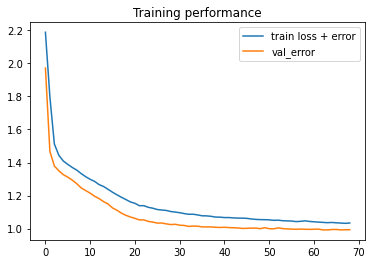

In [15]:
evaluationlib.show_loss_curves(history)

## Confusion matrix

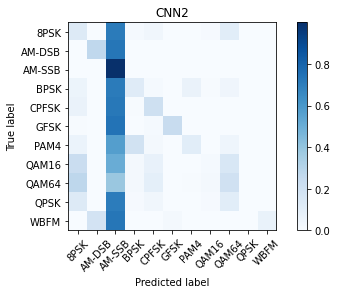

In [16]:
evaluationlib.plot_confusion_matrix(model, NEURAL_NETWORK_NAME, X_test, Y_test, BATCH_SIZE, classes)

## Confusion matrix for each SNR

Overall Accuracy:  0.09081818181818181


Overall Accuracy:  0.09090909090909091


Overall Accuracy:  0.09090909090909091


Overall Accuracy:  0.09063636363636364


Overall Accuracy:  0.091


Overall Accuracy:  0.091


Overall Accuracy:  0.09172727272727273


Overall Accuracy:  0.09681818181818182


Overall Accuracy:  0.15463636363636363


Overall Accuracy:  0.3370909090909091


Overall Accuracy:  0.5311929952572054


Overall Accuracy:  0.6258652094717668


Overall Accuracy:  0.6344202898550725


Overall Accuracy:  0.6078937661379564


Overall Accuracy:  0.5662215806568026


Overall Accuracy:  0.539051094890511


Overall Accuracy:  0.5655498907501821


Overall Accuracy:  0.5493372606774669


Overall Accuracy:  0.5401563610518835


Overall Accuracy:  0.5674891146589259


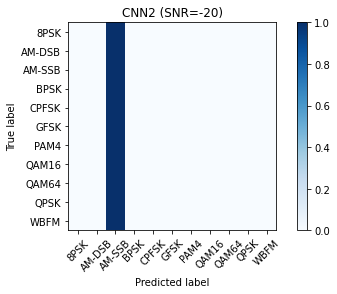

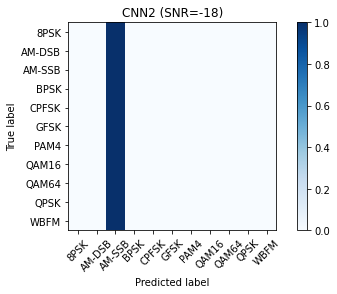

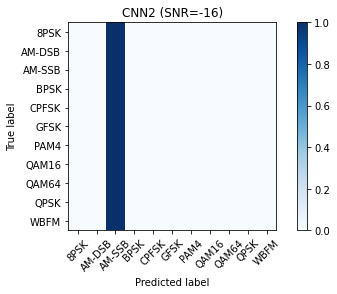

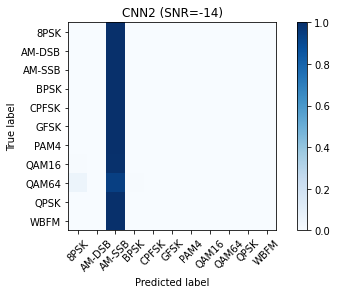

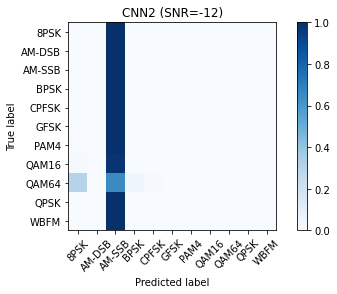

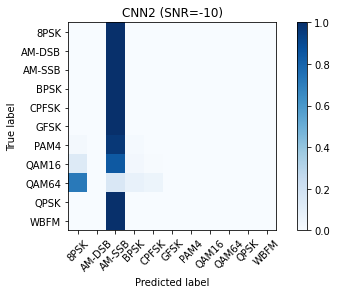

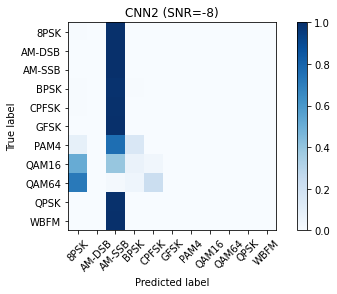

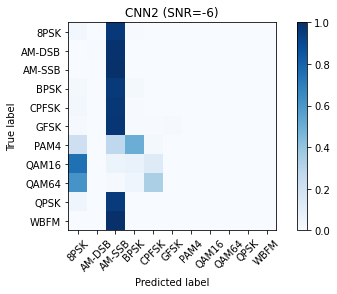

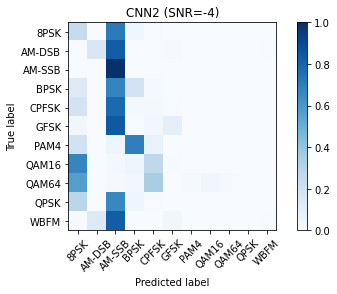

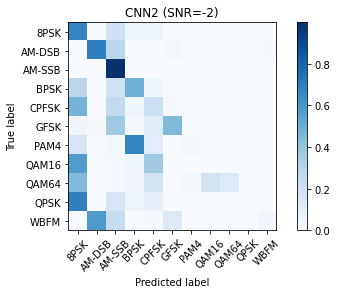

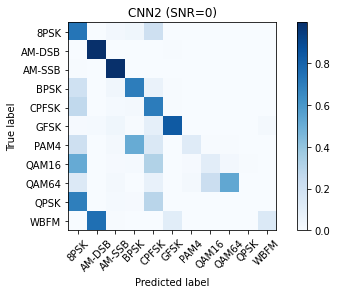

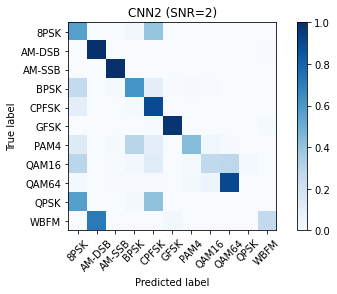

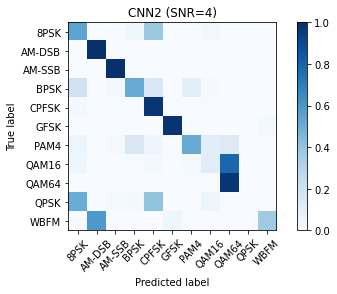

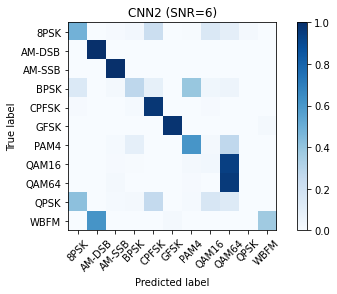

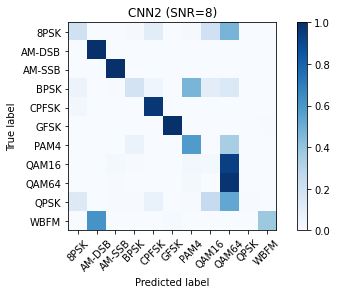

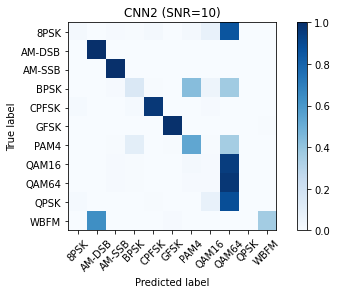

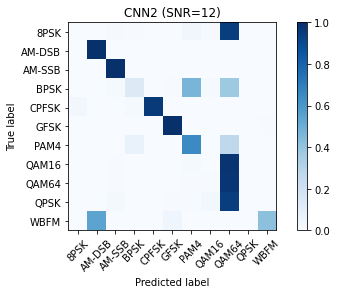

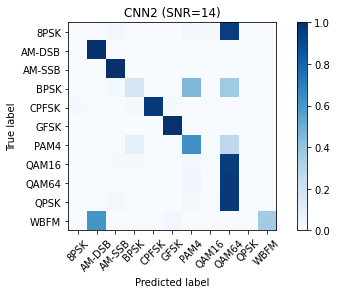

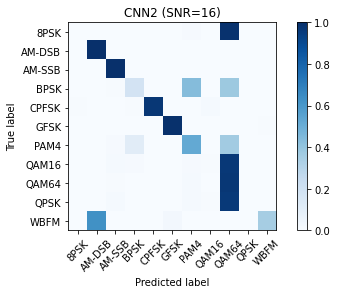

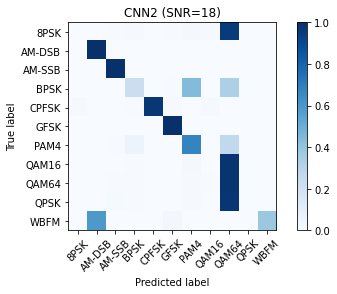

In [17]:
acc = evaluationlib.plot_confusion_matrix_each_snr(model, NEURAL_NETWORK_NAME, snrs, dataset_df, X_test, Y_test, test_index, classes)

## Accuracy performance

In [18]:
evaluationlib.accuracy_dataframe(acc)

,-20,-18,-16,-14,-12,-10,-8,-6,-4,-2,0,2,4,6,8,10,12,14,16,18
Accuracy %,9,9,9,9,9,9,9,9,15,33,53,62,63,60,56,53,56,54,54,56


In [19]:
# Save results to a pickle file for plotting later
# fd = open(OUTPUT_FILENAME,'wb')
# pickle.dump( ("CNN2", 0.5, acc) , fd )

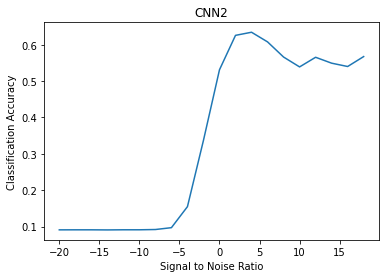

In [20]:
evaluationlib.accuracy_curve(snrs, acc, NEURAL_NETWORK_NAME)